In [2]:
import pandas as pd
import numpy as np
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/src/analysis/round1'

In [3]:
df1 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_-2.csv', delimiter = ";")
df2 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_-1.csv', delimiter = ";")
df3 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_0.csv', delimiter = ";")

In [4]:
df = pd.concat([df1, df2, df3])

In [5]:
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """

    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = min(bid_prices) if bid_prices else None

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = max(ask_prices) if ask_prices else None
        
        # 计算价差
        spread = best_ask - best_bid
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df

In [6]:
df = orderbook_preprocess(df)

In [7]:
def extract_product_df(df, symbol: str):
    df_product = df[df['product'] == symbol]
    #重新设置索引
    return df_product

In [8]:
df_ink = extract_product_df(df, 'KELP')
df_resin = extract_product_df(df, 'RAINFOREST_RESIN')
df_ink = extract_product_df(df, 'SQUID_INK')

In [59]:
from scipy.stats import kurtosis
def generate_features(df):
        df = df.copy()
        df['mid_price'] = (df['ask_price_1'] + df['bid_price_1']) / 2
        df['spread'] = df['ask_price_1'] - df['bid_price_1']
        df['vwap'] = (
            df['ask_price_1'] * df['ask_volume_1'] +
            df['ask_price_2'] * df['ask_volume_2'] +
            df['ask_price_3'] * df['ask_volume_3'] +
            df['bid_price_1'] * df['bid_volume_1'] +
            df['bid_price_2'] * df['bid_volume_2'] +
            df['bid_price_3'] * df['bid_volume_3']
        ) / (
            df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] +
            df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
        )

        df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
        df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
        df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
        df['log_return_5'] = np.log(df['mid_price']).diff(-5)
        df['log_return_1'] = np.log(df['mid_price']).diff(-1)
        df['vol_10'] = df['mid_price'].rolling(10).std()
        df['kurt_50'] = df['log_return_5'].rolling(50).apply(lambda x: kurtosis(x, fisher=False), raw=True)
        df['mid_mean_20'] = df['mid_price'].rolling(20).mean()
        df['mid_mean_100'] = df['mid_price'].rolling(100).mean()
        df['mid_mean_200'] = df['mid_price'].rolling(200).mean()
        df['mid_reversion_gap'] = df['mid_price'] - df['mid_mean_20']
        df['orderbook_imbalance'] = (df['bid_volume'] - df['ask_volume']) / (df['bid_volume'] + df['ask_volume'] )
        df['depth_ratio'] = df['bid_volume_1'] / (df['bid_volume'])
        df['relative_spread'] = df['spread'] / (df['mid_price'])
        df['imbalance_diff'] = df['orderbook_imbalance'].diff(-5)
        df['vol_diff'] = df['vol_10'].diff(-5)
        df['spread_change'] = df['spread'].diff(-5)
        df['return_vol_ratio'] = df['log_return_1'].abs() / (df['vol_10'] )

        #人工构造alpha
        df['alpha1'] = df['log_return_1'] - df['log_return_5']
        df['alpha2'] = df['mid_reversion_gap'] * df['orderbook_imbalance']
        df['alpha3'] = df['spread'] * df['depth_ratio']
        df['alpha4'] = df['vwap'] - df['mid_price']
        df['alpha5'] = df['relative_spread'] * df['return_vol_ratio']
        return df

def get_return(df):
    df = df.copy()
    df['log_return5'] = np.log(df['mid_price']).diff(5)
    #三分类构造target
    threshold = 0.01
    return_std = df['log_return'].std()
    df.loc[df['log_return'] < -return_std * 0.1, 'target'] = 0
    df.loc[abs(df['log_return']) < return_std * 0.1, 'target'] = 1
    df.loc[df['log_return'] > return_std * 0.1, 'target'] = 2

    return df


In [60]:
def preprocess_price(df):
    df = df.copy()
    df = generate_features(df)
    df= get_return(df)
    df.dropna(inplace=True)
    return df

In [61]:
df_ink = preprocess_price(df_ink)
df_resin = preprocess_price(df_resin)
df_ink = preprocess_price(df_ink)

In [62]:
df_ink.to_csv('../../../data/round1/round1_kelp.csv')
df_resin.to_csv('../../../data/round1/round1_resin.csv')
df_ink.to_csv('../../../data/round1/round1_ink.csv')


In [63]:
#研究因子和log_return5的相关性
def ic_analysis(df):
    feature_cols = [col for col in df.columns if col not in ['day', 'timestamp', 'product', 'profit_and_loss', 'log_return5']]

    df = df.loc[:,['log_return5'] + feature_cols]

    #对所有因子计算ic并且排序
    ic_dict = {}
    selected_cols = []
    for col in feature_cols:
        ic = df.loc[:,['log_return5',col]].corr().iloc[0,1]
        if abs(ic) > 0.5:
            selected_cols.append(col)
        ic_dict[col] = ic
    #排序
    ic_dict = dict(sorted(ic_dict.items(), key=lambda item: abs(item[1]), reverse=True))
    return ic_dict, selected_cols


In [64]:
kelp_dict, kelp_cols = ic_analysis(df_ink)
resin_dict, resin_cols = ic_analysis(df_resin)
ink_dict, ink_cols = ic_analysis(df_ink)


In [65]:
print(f"kelp_cols: {kelp_cols}, resin_cols: {resin_cols}, ink_cols: {ink_cols}")

kelp_cols: ['mid_reversion_gap', 'log_return', 'target'], resin_cols: ['bid_price_1', 'ask_price_1', 'mid_price', 'mid_reversion_gap', 'alpha4', 'log_return', 'target'], ink_cols: ['mid_reversion_gap', 'log_return', 'target']


In [66]:
print(kelp_dict)

{'log_return': 1.0, 'mid_reversion_gap': 0.7594350437546964, 'target': 0.6698982680579466, 'alpha4': -0.15229739656307223, 'ask_price_2': -0.10655195257411068, 'ask_volume_1': 0.10232837569056709, 'bid_price_2': 0.10054775075917632, 'depth_ratio': -0.10009159322061945, 'orderbook_imbalance': 0.09777960312361185, 'ask_bid_ratio': -0.09777960312361185, 'ask_volume_2': -0.09674070559788156, 'log_return_1': 0.09423146959135928, 'bid_volume_1': -0.09120692427344798, 'bid_volume_2': 0.0900761052849754, 'imbalance_diff': 0.07259101219076652, 'log_return_5': 0.05324512447787038, 'bid_price_3': 0.05238579871435235, 'bid_volume_3': 0.05156482881487027, 'ask_volume': -0.04482942829593514, 'ask_price_3': -0.044415332533875286, 'bid_volume': 0.04395891156877111, 'ask_volume_3': -0.04378991072177265, 'alpha3': -0.041186709691857386, 'vol_diff': 0.0405965960419094, 'ask_price_1': 0.03246050271270248, 'mid_price': 0.03238045969302771, 'bid_price_1': 0.03229906386863351, 'best_bid': 0.03120479094261992

In [67]:
print(resin_dict)

{'log_return': 1.0, 'target': 0.8636113367812753, 'mid_reversion_gap': 0.7245792457111428, 'mid_price': 0.7062412869598402, 'alpha4': -0.6500558777630261, 'ask_price_1': 0.5483043006420429, 'bid_price_1': 0.5394633642438463, 'log_return_5': 0.49922687060962595, 'log_return_1': 0.49876912200100665, 'ask_price_3': -0.3878505852911917, 'bid_price_3': 0.37496826042848025, 'ask_volume_3': -0.34712230830167984, 'bid_volume_3': 0.3381932628381969, 'vwap': 0.20073706211252362, 'ask_price_2': -0.20001611951722226, 'bid_price_2': 0.19165194192072646, 'best_ask': 0.16501964638860164, 'depth_ratio': -0.15696735798397485, 'ask_volume_1': 0.15556537322684363, 'bid_volume_1': -0.150512408640402, 'best_bid': 0.14791824361188816, 'ask_volume': -0.10369078427256184, 'bid_volume': 0.09887583911927089, 'ask_volume_2': 0.09352066272567561, 'bid_volume_2': -0.09177430752272428, 'orderbook_imbalance': 0.08421751363279818, 'ask_bid_ratio': -0.08421751363279818, 'alpha3': -0.07722629737355738, 'imbalance_diff'

In [68]:
print(ink_dict)

{'log_return': 1.0, 'mid_reversion_gap': 0.7594350437546964, 'target': 0.6698982680579466, 'alpha4': -0.15229739656307223, 'ask_price_2': -0.10655195257411068, 'ask_volume_1': 0.10232837569056709, 'bid_price_2': 0.10054775075917632, 'depth_ratio': -0.10009159322061945, 'orderbook_imbalance': 0.09777960312361185, 'ask_bid_ratio': -0.09777960312361185, 'ask_volume_2': -0.09674070559788156, 'log_return_1': 0.09423146959135928, 'bid_volume_1': -0.09120692427344798, 'bid_volume_2': 0.0900761052849754, 'imbalance_diff': 0.07259101219076652, 'log_return_5': 0.05324512447787038, 'bid_price_3': 0.05238579871435235, 'bid_volume_3': 0.05156482881487027, 'ask_volume': -0.04482942829593514, 'ask_price_3': -0.044415332533875286, 'bid_volume': 0.04395891156877111, 'ask_volume_3': -0.04378991072177265, 'alpha3': -0.041186709691857386, 'vol_diff': 0.0405965960419094, 'ask_price_1': 0.03246050271270248, 'mid_price': 0.03238045969302771, 'bid_price_1': 0.03229906386863351, 'best_bid': 0.03120479094261992

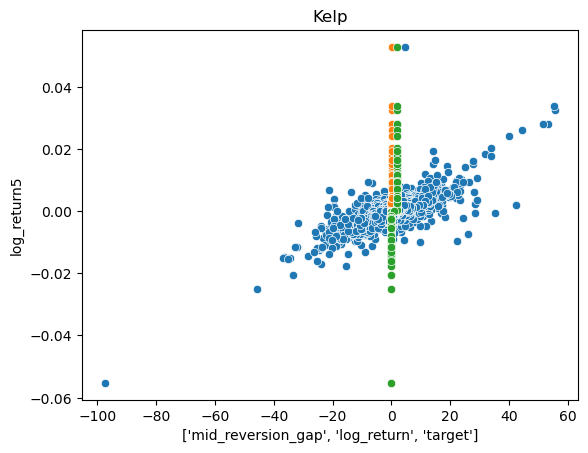

In [69]:
#研究因子和log_return5的关系
import matplotlib.pyplot as plt
import seaborn as sns

for col in kelp_cols:
    sns.scatterplot(x=df_ink[col], y=df_ink['log_return5'])
    plt.xlabel(kelp_cols)
    plt.ylabel('log_return5')
    plt.title('Kelp')

plt.show()

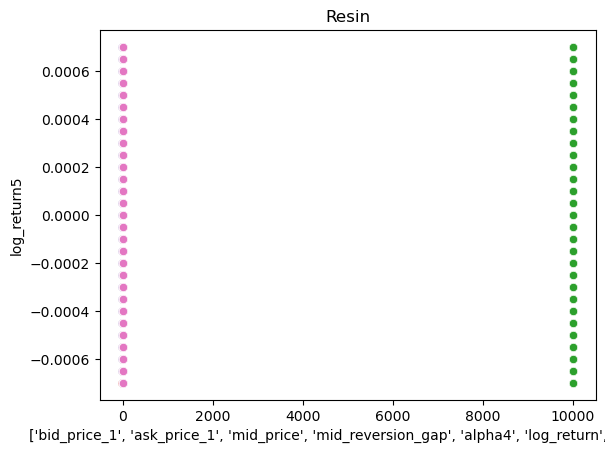

In [70]:
for col in resin_cols:
    sns.scatterplot(x=df_resin[col], y=df_resin['log_return5'])
    plt.xlabel(resin_cols)
    plt.ylabel('log_return5')
    plt.title('Resin')
plt.show()

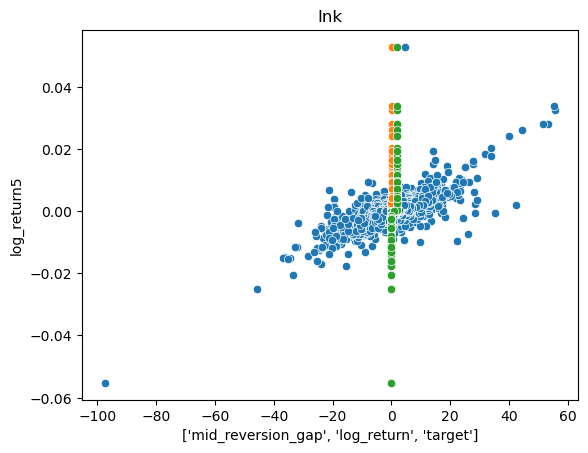

In [71]:
for col in ink_cols:
    sns.scatterplot(x=df_ink[col], y=df_ink['log_return5'])
    plt.xlabel(ink_cols)
    plt.ylabel('log_return5')
    plt.title('Ink')

<Axes: xlabel='mid_price', ylabel='Count'>

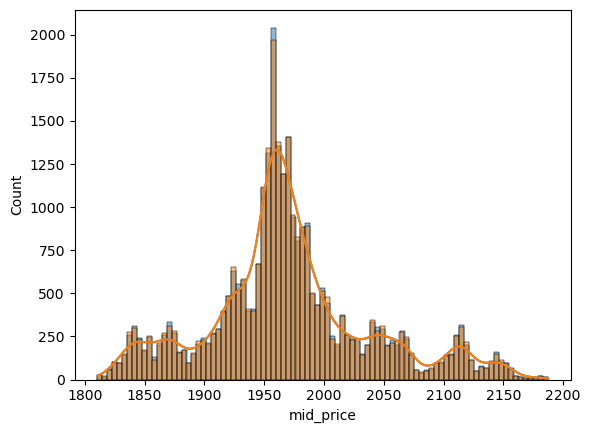

In [72]:
#可视化
import matplotlib.pyplot as plt
import seaborn as sns

#基本因子分布
columns = ['mid_price', 'vwap', 'spread', 'orderbook_imbalance', 'ask_bid_ratio']

sns.histplot(df_ink['mid_price'], kde=True)
sns.histplot(df_ink['vwap'], kde = True)


count    29168.000000
mean         0.000163
std          0.061988
min         -0.675676
25%          0.000000
50%          0.000000
75%          0.015873
max          0.818182
Name: orderbook_imbalance, dtype: float64
Non zero ratio of orderbook imbalance: 0.49883433900164564


<Axes: xlabel='orderbook_imbalance', ylabel='Count'>

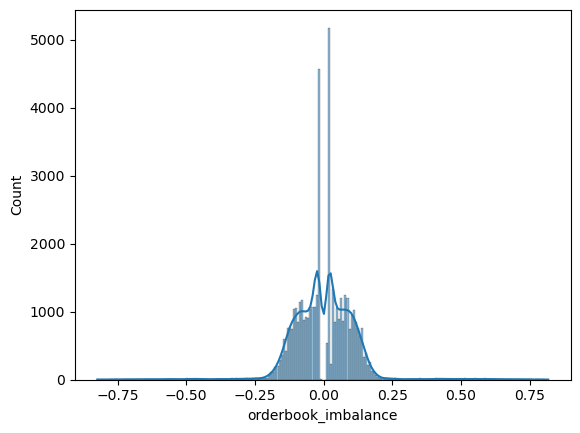

In [73]:
print(df_ink['orderbook_imbalance'].describe())

#计算0的个数和非0个数
zero_count = df_ink['orderbook_imbalance'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_ink)
print(f'Non zero ratio of orderbook imbalance: {non_zero_ratio}')

df_ink_filterd = df[df['orderbook_imbalance']!= 0]
sns.histplot(df_ink_filterd['orderbook_imbalance'], kde = True)


count    29168.000000
mean        -0.000163
std          0.061988
min         -0.818182
25%         -0.015873
50%          0.000000
75%          0.000000
max          0.675676
Name: ask_bid_ratio, dtype: float64
Non zero ratio of ask bid ratio: 0.49883433900164564


<Axes: xlabel='ask_bid_ratio', ylabel='Count'>

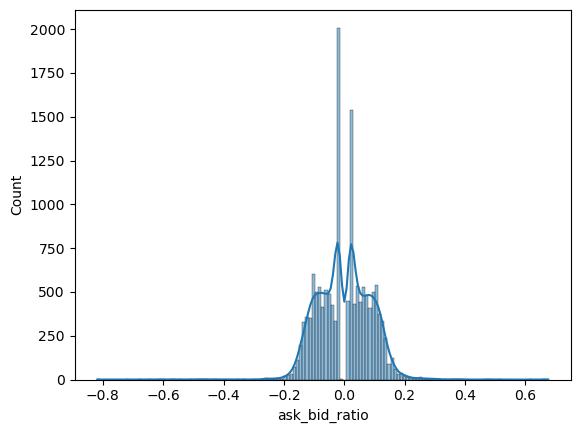

In [74]:
print(df_ink['ask_bid_ratio'].describe())
#计算0的个数和非0个数
zero_count = df_ink['ask_bid_ratio'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_ink)
print(f'Non zero ratio of ask bid ratio: {non_zero_ratio}')

df_ink_filterd = df_ink[df_ink['ask_bid_ratio'] != 0]
sns.histplot(df_ink_filterd['ask_bid_ratio'], kde = True)

In [75]:
import math
def fractional_derivative(ts, alpha, n_terms=10):
    """
    计算时间序列 ts 的分数阶导数
    参数:
        ts: 时间序列
        alpha: 阶数
        n_terms: 历史项的数量，控制内存长短

    返回:
        分数阶导数序列（长度与 ts 相同，前面一些值为 nan）
    """

    def binomial_coeff(a, k):
        return math.gamma(a + 1) / (math.gamma(k + 1) * math.gamma(a - k + 1))

    ts = np.asarray(ts)
    result = np.full_like(ts, np.nan, dtype=np.float64)

    for t in range(n_terms, len(ts)):
        val = 0.0
        for k in range(n_terms):
            coeff = (-1) ** k * binomial_coeff(alpha, k)
            val += coeff * ts[t - k]
        result[t] = val
    return result

def rolling_window(ts, window_length: int):
    ts_diff = ts.diff(window_length)
    ts_vol = ts.rolling(window_length).std()
    ts_mean = ts.rolling(window_length).mean()
    ts_zscore = (ts - ts_mean) / ts_vol
    return ts_diff, ts_vol, ts_mean, ts_zscore


In [76]:
from scipy.stats import kurtosis

def get_return(df):
    df = df.copy()
    df['mid_price_diff_5'] = df['mid_price'] - df['mid_price'].shift(5)
    df['log_return_5'] = np.log(df['mid_price']).diff(5)
    df.dropna(inplace=True)
    k = kurtosis(df['log_return_5'])
    print("Kurtosis of log_return_5: ", k)
    return df

In [77]:
sns.histplot(df_ink['mid_price_diff'])

KeyError: 'mid_price_diff'

In [ ]:
def IC_IR(df, factor_column: str, return_column: str, risk_free_rate: float):
    """
    Calculate the Information Coefficient (IC) and Implied Risk-Free Rate (IRR) of a factor using the CAPM model.
    :param df: DataFrame with columns for the factor, return, and market return.
    :param factor_column: Name of the column containing the factor values.
    :param return_column: Name of the column containing the return values.
    :param risk_free_rate: Risk-free rate used in the CAPM model.
    :return: Tuple of the IC and IRR values.
    """
    # Calculate the market return
    market_return = df[return_column].mean()
    # Calculate the CAPM beta
    beta = (df[return_column] - risk_free_rate - df[factor_column] * market_return) / (df[factor_column] ** 2)

    # Calculate the CAPM alpha
    alpha = market_return - risk_free_rate - beta * df[factor_column]

    # Calculate the Information Coefficient (IC)
    ic = (beta ** 2) / (1 - beta ** 2)

    # Calculate the Implied Risk-Free Rate (IRR)
    irr = (1 + alpha) / (1 + beta)
    return ic, irr


In [ ]:
df_ink['kurt_50'] = df_ink['log_return_5'].rolling(50).apply(kurtosis)
df_ink.dropna(inplace=True)
ic, irr = IC_IR(df_ink, 'log_return_5', 'kurt_50', 0)
#print(ic, irr)


In [ ]:
print(ic.describe())
sns.histplot(ic, kde=False)

count    26778.000000
mean        -1.000000
std          0.000036
min         -1.005501
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         -1.000000
dtype: float64


In [ ]:
def calculate_factors(df):
    """
    计算因子：
    订单簿因子：orderbook_imbalance, ask_bid_ratio（已实现）
    基本因子：对数收益率（5）， 波动率（10）
    肥尾因子：kurt(50)
    衍生因子：上述的1阶差分和1/2阶差分
    """
    df['log_return5'] = np.log(df['mid_price']).diff(5)
    df['vol10'] = df['mid_price'].rolling(10).std()
    df['kurt50'] = df['log_return_5'].rolling(10).kurt()
    df['orderbook_imbalance_5_1/2'] = fractional_derivative(df['orderbook_imbalance'], 1/2, 5)
    df['orderbook_imbalance_5_1'] = fractional_derivative(df['orderbook_imbalance'], 1, 5)
    df['ask_bid_ratio_5_1/2'] = fractional_derivative(df['ask_bid_ratio'], 1/2, 5)
    df['ask_bid_ratio_5_1'] = fractional_derivative(df['ask_bid_ratio'], 1, 5)
    df['vol10_5_1/2'] = fractional_derivative(df['vol10'], 0.5, 5)
    df['vol10_5_1'] = fractional_derivative(df['vol10'], 1, 5)
    df['kurt50_5_1/2'] = fractional_derivative(df['kurt50'], 0.5, 5)
    df['kurt_50_1'] = fractional_derivative(df['kurt50'], 1, 5)
    return df

In [79]:
df_ink0 = df_ink[df_ink['day'] == -2]
df_ink1 = df_ink[df_ink['day'] == -1]
df_ink2 = df_ink[df_ink['day'] == 0]


In [80]:
print(df_ink0.columns)

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'best_bid', 'best_ask', 'spread', 'vwap', 'orderbook_imbalance',
       'ask_volume', 'bid_volume', 'ask_bid_ratio', 'log_return_5',
       'log_return_1', 'vol_10', 'kurt_50', 'mid_mean_20', 'mid_reversion_gap',
       'depth_ratio', 'relative_spread', 'imbalance_diff', 'vol_diff',
       'spread_change', 'return_vol_ratio', 'alpha1', 'alpha2', 'alpha3',
       'alpha4', 'alpha5', 'log_return', 'target', 'log_return5',
       'mid_mean_100', 'mid_mean_200'],
      dtype='object')


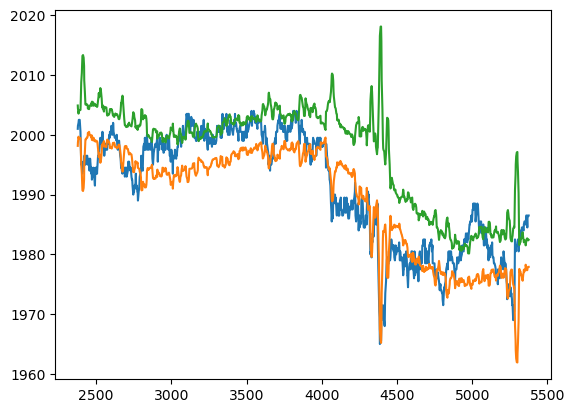

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_ink0['mid_price'][:1000])
plt.plot(df_ink0['mid_mean_200'][:1000]-df_ink0['vol_10'][:1000] * 3)
plt.plot(df_ink0['mid_mean_200'][:1000]+df_ink0['vol_10'][:1000] * 3)
#plt.plot(df_ink1['mid_price'][:400])
#plt.plot(df_ink2['mid_price'][:400])
#以vol_10为宽度、mid_price为中心，画出标准差的上下界
#plt.fill_between(df_ink0.index[:400], df_ink0['mid_price'][:400]-df_ink0['vol_10'][:400], df_ink0['mid_price'][:400]+df_ink0['vol_10'][:400], alpha=1)
#plt.fill_between(df_ink1.index[:400], df_ink2['mid_price'][:400]-df_ink2['vol_10'][:400], df_ink2['mid_price'][:400]+df_ink2['vol_10'][:400], alpha=1)
#plt.fill_between(df_ink2.index[:400], df_ink2['mid_price'][:400]-df_ink2['vol_10'][:400], df_ink2['mid_price'][:400]+df_ink2['vol_10'][:400], alpha=1)
plt.show()


In [ ]:
print(df_ink0.columns)

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'best_bid', 'best_ask', 'spread', 'vwap', 'orderbook_imbalance',
       'ask_volume', 'bid_volume', 'ask_bid_ratio', 'log_return_5',
       'log_return_1', 'vol_10', 'kurt_50', 'mid_mean_20', 'mid_reversion_gap',
       'depth_ratio', 'relative_spread', 'imbalance_diff', 'vol_diff',
       'spread_change', 'return_vol_ratio', 'alpha1', 'alpha2', 'alpha3',
       'alpha4', 'alpha5', 'log_return', 'target', 'log_return5'],
      dtype='object')


In [95]:
print(df_ink0)

       day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
2378    -2      79200  SQUID_INK         2000            30          0.0   
2379    -2      79300  SQUID_INK         2000            29          0.0   
2383    -2      79400  SQUID_INK         2000            20          0.0   
2385    -2      79500  SQUID_INK         2001             2       2000.0   
2390    -2      79600  SQUID_INK         2001            27          0.0   
...    ...        ...        ...          ...           ...          ...   
29986   -2     999500  SQUID_INK         2000            26          0.0   
29990   -2     999600  SQUID_INK         2001            30          0.0   
29992   -2     999700  SQUID_INK         2001            22          0.0   
29994   -2     999800  SQUID_INK         2002            26          0.0   
29999   -2     999900  SQUID_INK         2003             4       2002.0   

       bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...    alpha2  \
2378     

break
False    8758
True      450
Name: count, dtype: int64


/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_28968/1145285450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ink0['break'] = (df_ink0['mid_price'] > df_ink0['mid_mean_200'] + band_width) | (df_ink0['mid_price'] < df_ink0['mid_mean_200'] - band_width)
/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_28968/1145285450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ink0['break'] = df_ink0['break'].apply(lambda x: 1 if x == True else 0)


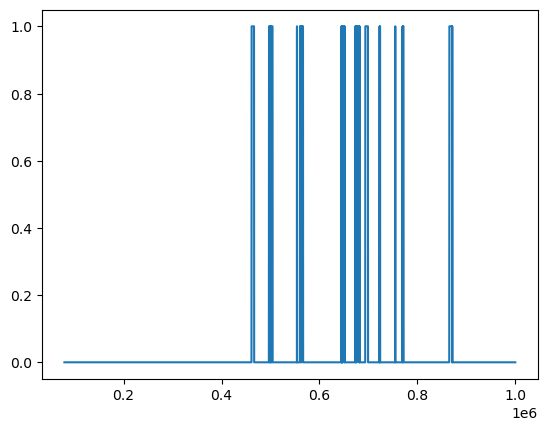

In [98]:
#当mid_price超出或者少于mid_mean_20 +- vol_10，记录break = True，否则为False
band_width = 30
df_ink0['break'] = (df_ink0['mid_price'] > df_ink0['mid_mean_200'] + band_width) | (df_ink0['mid_price'] < df_ink0['mid_mean_200'] - band_width)

print(df_ink0['break'].value_counts())
#如果break = True就赋值为1
df_ink0['break'] = df_ink0['break'].apply(lambda x: 1 if x == True else 0)
plt.plot(df_ink0['timestamp'], df_ink0['break'])


break
False    9797
True      203
Name: count, dtype: int64


/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_28968/4190503853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ink1['break'] = (df_ink1['mid_price'] > df_ink1['mid_mean_200'] + band_width) | (df_ink1['mid_price'] < df_ink1['mid_mean_200'] - band_width)
/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_28968/4190503853.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ink1['break'] = df_ink1['break'].apply(lambda x: 1 if x == True else 0)


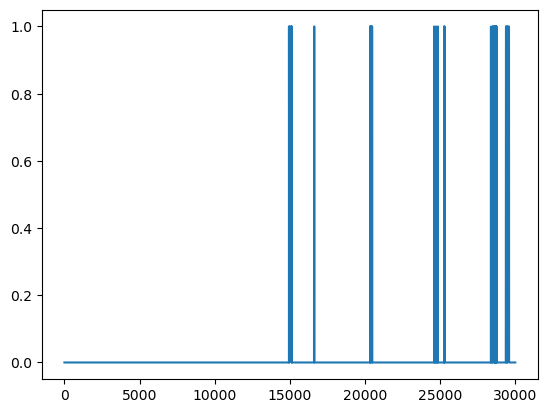

In [ ]:
#当mid_price超出或者少于mid_mean_20 +- vol_10，记录break = True，否则为False
band_width = 30
df_ink1['break'] = (df_ink1['mid_price'] > df_ink1['mid_mean_200'] + band_width) | (df_ink1['mid_price'] < df_ink1['mid_mean_200'] - band_width)

print(df_ink1['break'].value_counts())
#如果break = True就赋值为1
df_ink1['break'] = df_ink1['break'].apply(lambda x: 1 if x == True else 0)
plt.plot(df_ink1['break'])

break
False    9891
True       69
Name: count, dtype: int64


/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_28968/3747546581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ink2['break'] = (df_ink2['mid_price'] > df_ink2['mid_mean_200'] + band_width) | (df_ink2['mid_price'] < df_ink2['mid_mean_200'] - band_width)
/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_28968/3747546581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ink2['break'] = df_ink2['break'].apply(lambda x: 1 if x == True else 0)


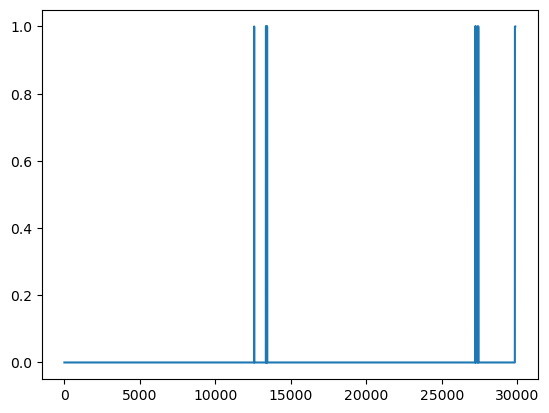

In [94]:
#当mid_price超出或者少于mid_mean_20 +- vol_10，记录break = True，否则为False
band_width = 30
df_ink2['break'] = (df_ink2['mid_price'] > df_ink2['mid_mean_200'] + band_width) | (df_ink2['mid_price'] < df_ink2['mid_mean_200'] - band_width)

print(df_ink2['break'].value_counts())
#如果break = True就赋值为1
df_ink2['break'] = df_ink2['break'].apply(lambda x: 1 if x == True else 0)
plt.plot(df_ink2['break'])

In [ ]:
df_ink['deviation'] = df['mid_price']